Imports
==============================================================================================

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from keras.callbacks import TensorBoard, History, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import Adam
from pathlib import Path
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from evaluation import *
from machineLearningModel import *
from statsmodels.graphics.tsaplots import plot_acf

Using TensorFlow backend.


Configuration
==============================================================================================

In [44]:
# fix random seed for reproducibility
np.random.seed(13)

## net params
num_layers = 3#2#2#1#4#3#6
num_neurons = 50#300#50#100#500
batch_size = 128#500#1000
dropout_rate = 0
const_features = ['latitude', 'longitude', 'altitude', 'modules_per_string', 'strings_per_inverter', 'tilt',
                  'azimuth', 'albedo', 'Technology', 'BIPV', 'A_c', 'N_s', 'pdc0', 'gamma_pdc']#, 'SystemID']#15
dyn_features = ['Wind Direction_x', 'Wind Direction_y', 'Total Cloud Cover', 'Low Cloud Cover', 'Medium Cloud Cover',
                'High Cloud Cover', 'Wind Speed', 'Wind Gust', 'Total Precipitation',
                'Snow Fraction', 'Mean Sea Level Pressure', 'DIF - backwards', 'DNI - backwards', 'Shortwave Radiation',
                'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']#20
#const_features = ['SystemID']
#dyn_features = ['DIF - backwards', 'DNI - backwards', 'Shortwave Radiation', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']#, 'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']
target_features = ['power']
drop_features = ['power_pvlib']
act_fct = 'relu'
out_act = 'linear' # linear, relu
loss_fct = 'mae' # mse, mae
optim = 'adam'#Adam(lr=0.00001)#'adam'
metrics = []
history = History()
val_history = History()

## data params
filename = './data/full_data_5_systems.csv'
correlations = []#'pearson', 'spearman', 'kendall']
timesteps = 5#1#12#5#1#3#2#1#5#168#2190#336#72#24#5#24
method = 'dilated' # randfor, mlp, lstm, dilated
flat = ['randfor', 'mlp']
recursive = True#True#False
system = 3.0

## training params
pretraining = True
wfvtraining = True
tensorboard = False
callbacks = [history, EarlyStopping(patience=10, restore_best_weights=True), ModelCheckpoint('./saved_models/best_model.h5', save_best_only=True)]#, verbose=1)] #EarlyStopping(patience=5), 
shuffle = False
epochs = 200#50#20
val_split = 1.0/10.0
forecast_horizon = 24#3#1#6#24#3#6#3#24
sliding_window = 169#8760#672#3#8#24#72#672#336#8760#672#336#24#8760
dir = './test_results/'
if not os.path.exists(dir):
    os.makedirs(dir)

# input shape
if method in flat:
    if recursive:
        shape = (len(const_features + dyn_features) + timesteps * (len(dyn_features + target_features)) + 1,)
    else:
        shape = (len(const_features) + timesteps * (len(dyn_features + target_features)) + forecast_horizon * len(dyn_features),)
else:
    if recursive:
        shape = (timesteps + 1, len(const_features + dyn_features + target_features) + 1)
    else:
        shape = (timesteps, len(const_features + target_features) + len(dyn_features) * (forecast_horizon + timesteps))

# output shape
if recursive:
    out_dim = len(target_features)
else:
    out_dim = forecast_horizon

Data Preprocessing
==============================================================================================

In [73]:
suffix = ''
if method not in flat:
    suffix = '_2D'
pfname = dir + 'preprocessed_data_t-'+str(timesteps)+'_f'+str(shape[0])+suffix+'.csv'
prep = Path(pfname)
if prep.exists() and False:
    print('Loading preprocessed dataset ...')
    pvlib = np.array_split(pd.read_csv(filename, skipinitialspace=True).set_index(['time', 'SystemID']), 5)[int(system)].power_pvlib
    dataset = pd.read_csv(pfname, skipinitialspace=True).set_index(['time', 'SystemID'])
    
    dataset = dataset.dropna()
    train, test = dataset[:('2015-10-10 23:00:00', system)], dataset[('2015-10-11 00:00:00', system):]
    trainX = train.drop(target_features, axis=1)
    trainY = [train[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(train))]

    testX = test.drop(target_features, axis=1)
    testY = [test[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(test))]

    for f in range(1, forecast_horizon):
        trainY[-f] = np.pad(trainY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
        testY[-f] = np.pad(testY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
    trainY = np.array(trainY[:-forecast_horizon])
    trainX = trainX[:-forecast_horizon]
    testY = np.array(testY[:-forecast_horizon])
    testX = testX[:-forecast_horizon]
    idx = testX.index.values
else:
    print('Data preprocessing ...')
    dataframe = pd.read_csv(filename, skipinitialspace=True).set_index(['time', 'SystemID'])
    dataframe = np.array_split(dataframe, 5)
    pvlibs = []
    trainXs = []
    trainYs = []
    testXs = []
    testYs = []
    idxs = []
    for s in range(5):
        df = dataframe[s]
        
        #df = np.array_split(df, 5)[int(system)] #-1 ##################################
        #pvlib = df.power_pvlib
        pvlibs.append(df.power_pvlib)
        dataset = df[const_features + dyn_features + target_features].copy()

        if method in flat:
            if recursive:
                #separate system
                for i in range(1, timesteps + 1):
                    for feature in dyn_features + target_features:
                        sys.stdout.write("Shifting %1i/%i %24s\r" % (i, timesteps, feature))
                        sys.stdout.flush()
                        dataset[feature + ' t-' + str(i)] = dataset.shift(i)[feature]
                print('Shifting done.                ')

                dataset['forecast_horizon'] = 0
                p = dataset[target_features]
                dataset = dataset.drop(target_features, axis=1)
                for f in target_features:
                    dataset[f] = p[f]
                dataset = dataset.dropna()

                sys.stdout.write("Writing to file ...\r")
                sys.stdout.flush()
                dataset.to_csv(pfname, encoding='utf-8')
                print('Writing done.                ')

                if correlations:
                    sys.stdout.write('Computing correlations ...\r')
                    sys.stdout.flush()
                    for corr in correlations:
                        sys.stdout.write("Computing %23s correlation matrix\r" % (corr))
                        sys.stdout.flush()
                        dataset.corr(method=corr).to_csv(dir + corr + '_correlations.csv', encoding='utf-8')
                    print('Correlations done.                   ')

                train, test = dataset[:('2015-10-10 23:00:00', s)], dataset[('2015-10-11 00:00:00', s):]
                trainX, trainY = train.iloc[:,:-len(target_features)], train.iloc[:,-len(target_features):]
                testX, testY = test.iloc[:,:-len(target_features)], test.iloc[:,-len(target_features):]
                idx = testX.index.values
            else:
                for i in range(forecast_horizon, 1, -1):
                    for feature in dyn_features:
                        sys.stdout.write("Shifting %1i/%i %24s \r" % (i, forecast_horizon, feature))
                        sys.stdout.flush()
                        dataset[feature + ' t+' + str(i)] = dataset.shift(i)[feature]

                #separate system
                for i in range(1, timesteps + 1):
                    for feature in dyn_features + target_features:
                        sys.stdout.write("Shifting %1i/%i %25s \r" % (i, timesteps, feature))
                        sys.stdout.flush()
                        dataset[feature + ' t-' + str(i)] = dataset.shift(i)[feature]
                print('Shifting done.                                ')

                sys.stdout.write("Writing to file ...\r")
                sys.stdout.flush()
                dataset.to_csv(pfname, encoding='utf-8')
                print('Writing done.                                ')

                if correlations:
                    sys.stdout.write('Computing correlations ...\r')
                    sys.stdout.flush()
                    for corr in correlations:
                        sys.stdout.write("Computing %23s correlation matrix\r" % (corr))
                        sys.stdout.flush()
                        dataset.corr(method=corr).to_csv(dir + corr + '_correlations.csv', encoding='utf-8')
                    print('Correlations done.                   ')

                train, test = dataset[:('2015-10-10 23:00:00', s)], dataset[('2015-10-11 00:00:00', s):]
                trainX = train.drop(target_features, axis=1)
                trainY = [train[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(train))]

                testX = test.drop(target_features, axis=1)
                testY = [test[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(test))]

                for f in range(1, forecast_horizon):
                    trainY[-f] = np.pad(trainY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
                    testY[-f] = np.pad(testY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
                trainY = np.array(trainY[:-forecast_horizon])
                trainX = trainX[:-forecast_horizon]
                testY = np.array(testY[:-forecast_horizon])
                testX = testX[:-forecast_horizon]
                idx = testX.index.values
        else:
            if recursive:
                dataset['forecast_horizon'] = 0
                p = dataset[target_features]
                dataset = dataset.drop(target_features, axis=1)
                for f in target_features:
                    dataset[f] = p[f]
                dataset = dataset.dropna()

                x = []
                for i in range(timesteps+1, len(dataset)+1):
                    sys.stdout.write("System %i/5: %5i/%i                \r" % (s+1, i, len(dataset)))
                    sys.stdout.flush()
                    d = dataset.iloc[i-timesteps-1:i].copy()
                    d.iloc[-1, -len(target_features):] = -1
                    x.append(d.values)
                x = np.array(x)
                y = dataset[target_features].iloc[timesteps:]
                split = dataset[:('2015-10-11 00:00:00', s)].iloc[timesteps+1:].shape[0]#'2015-10-12 07:00:00'
                trainX, testX = x[:split], x[split:]
                trainY, testY = y.iloc[:split].values, y.iloc[split:].values
                idx = y.iloc[split:].index
            else:
                x = []
                y = []
                for i in range(timesteps, len(dataset)-forecast_horizon):
                    weather = dataset.iloc[i-timesteps:i+forecast_horizon][dyn_features].values
                    const = dataset.iloc[i-timesteps:i][const_features+target_features].values
                    d = []
                    for c in const:
                        d.append(np.concatenate((weather.flatten(), c), axis=0))
                    x.append(d)
                    y.append(dataset.iloc[i:i+forecast_horizon][target_features].values)
                x = np.array(x)
                y = np.array(y)
                y = y.reshape(y.shape[0], y.shape[1])

                split = dataset[:('2015-10-11 00:00:00', s)].iloc[timesteps:].shape[0]
                trainX, testX = x[:split], x[split:]
                trainY, testY = y[:split], y[split:]
                idx = dataset[('2015-10-11 00:00:00', s):].index[1:-1]
        trainXs.append(trainX)
        trainYs.append(trainY)
        testXs.append(testX)
        testYs.append(testY)
        idxs.append(idx)
    print('Concatenating datasets ...                  ')
    trainX = pd.concat(trainXs)
    trainY = pd.concat(trainYs)
    testX = pd.concat(testXs)
    testY = pd.concat(testYs)
    idx = pd.concat(idxs)
print('Preprocessing done.')

Data preprocessing ...
Concatenating datasets ...                  


TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [78]:
trainX = np.concatenate(trainXs)
trainY = np.concatenate(trainYs)
testX = np.concatenate(testXs)
testY = np.concatenate(testYs)
idx = np.concatenate(idxs)

In [ ]:
dataset = dataset.dropna()
train, test = dataset[:('2015-10-10 23:00:00', system)], dataset[('2015-10-11 00:00:00', system):]
trainX = train.drop(target_features, axis=1)
trainY = [train[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(train))]

testX = test.drop(target_features, axis=1)
testY = [test[target_features].iloc[i:i+forecast_horizon].values.flatten() for i in range(len(test))]

for f in range(1, forecast_horizon):
    trainY[-f] = np.pad(trainY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
    testY[-f] = np.pad(testY[-f], (0, forecast_horizon-f), mode='constant', constant_values=(np.nan,))
trainY = np.array(trainY[:-24])
trainX = trainX[:-24]
testY = np.array(testY)
idx = testX.index.values

Build Model
==============================================================================================

In [79]:
if method is 'randfor':
    model = RandomForest(200, 0.13, 'mse')#216 0.63 mse   10, 0.33, 'mae',  200, 0.13, 'mse': 597
else:
    if tensorboard:
        print('tensorboard activated')
        callbacks.append(TensorBoard(log_dir='./tensorboard', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False))

    if method is 'mlp':
        model = MultiLayerPerceptron(shape, out_dim, num_layers, num_neurons, loss_fct, optim,
                                     act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                     epochs, val_split, callbacks, 1, True)
    elif method is 'lstm':
        model = LongShortTermMemory(shape, out_dim, num_layers, num_neurons, loss_fct, optim,
                                    act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                    epochs, val_split, callbacks, 1, True)
    elif method is 'dilated':
        model = DilatedConvolution(shape, out_dim, 3, 2, 32, 'causal', loss_fct, optim, #best: 3, 2, 32
                                   act_fct, out_act, metrics, dropout_rate, dir + 'model.png', batch_size,
                                   epochs, val_split, callbacks, 1, True)

Using DilatedConvolution



Training
==============================================================================================

In [81]:
if pretraining:
    X = trainX#testX#trainX
    y = trainY#testY#trainY

    if shuffle:# or True:
        df = pd.DataFrame(np.concatenate((trainX, trainY), axis=1))
        df = df.sample(frac=1).values
        y = pd.DataFrame(df[:, -len(target_features):])
        X = pd.DataFrame(df[:, :-len(target_features)])
        
    print('Start pretraining ...')    
    model.learn(X, y, val_idx=int(len(y) / 10))

    if method is not 'randfor':
        name = './saved_models/pretrained_t-'+str(timesteps)+'_f'+str(shape[0])+'_e'+str(epochs)+'_b'+str(batch_size)+'_sys'+str(system)
        # serialize model to JSON
        model_json = model.model.to_json()
        with open(name + ".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.model.save_weights(name + ".h5")
        print("Saved model to disk")

Start pretraining ...
Train on 306698 samples, validate on 34077 samples
Epoch 1/200
306698/306698 [==============================] - 32s 106us/step - loss: 119.9962 - val_loss: 63.8365
Epoch 2/200
306698/306698 [==============================] - 32s 105us/step - loss: 61.2438 - val_loss: 45.7369
Epoch 3/200
306698/306698 [==============================] - 34s 111us/step - loss: 45.2757 - val_loss: 98.6556
Epoch 4/200
306698/306698 [==============================] - 29s 96us/step - loss: 40.0589 - val_loss: 39.2717
Epoch 5/200
306698/306698 [==============================] - 32s 103us/step - loss: 34.3252 - val_loss: 28.5892
Epoch 6/200
306698/306698 [==============================] - 30s 99us/step - loss: 32.9027 - val_loss: 36.3205
Epoch 7/200
306698/306698 [==============================] - 28s 92us/step - loss: 30.6447 - val_loss: 34.4096
Epoch 8/200
306698/306698 [==============================] - 30s 99us/step - loss: 29.5133 - val_loss: 26.7839
Epoch 9/200
306698/306698 [=======

In [63]:
if method is not 'randfor':
    # load best
    model.model.load_weights('./saved_models/best_model.h5')

Walk-Forward Validation
==============================================================================================

In [105]:
model.epochs = 1#50#1#50#5
model.batch_size = 128#1024#128
model.verbose = 0
model.callbacks = [val_history] 
model.validation_split = 0.0
model.shuffle = True#False#True
wfvtraining = True#True
sliding_window = 168#1024#8760#168#24#169
threshold = 0#0#10 #200 100 150 500 1000 2000

predictions = []
pred_err = []
length = len(testX)#10000#len(testX)#3000#
trainset = []
trainy = []
perr = -1
for i in range(length):
    if i == 1:#sliding_window + 1:
        model.validation_split = 1.0/100.0
        model.callbacks.append(EarlyStopping(patience=7, restore_best_weights=True))#5 , baseline=600
        #model.epochs = 5
    if method is not 'randfor' and i > sliding_window + 1 and wfvtraining:
        loss = h.history['loss'][-1]
        val_loss = min(h.history['val_loss'])
    else:
        loss = -1
        val_loss = -1

    sys.stdout.write("Walk-Forward Validation %5i/%i: %5d %5d, pred: %6d\r" % (i+1, length, loss, val_loss, perr))
    sys.stdout.flush()
    
    
    if method in flat:
        if recursive:
            # initialize values for lagged power columns
            p = []
            for l in range(1, timesteps + 1):
                p.append(testX.iloc[i:i+1,:]['power t-'+str(l)].values[0])

            ps = []
            ts = []
            ty = []
            for f in range(forecast_horizon):
                # build input vector for future timestep
                t = testX.iloc[i+f:i+1+f,:].copy()
                for l in range(timesteps-1, 1, -1):
                    t['power t-' + str(l+1)] = p[l]
                    p[l] = p[l-1]
                t['power t-1'] = p[0]
                t['forecast_horizon'] = f
                ts.append(t)
                ty.append(testY.iloc[i+f:i+1+f,:])

                # make prediction for input new vector
                if t.size > 0:
                    tmp = model.forecast(t)
                    p[0] = tmp.item(0)
                    ps.append(p[0])
            
            perr = np.mean(np.abs(testY.iloc[i:i+forecast_horizon,:].values.flatten() - ps))
            pred_err.append(perr)
            predictions.append(pd.DataFrame(ps))

            trainset += ts
            trainy += ty
            if i - sliding_window >= 0:
                trainset = trainset[-(sliding_window*forecast_horizon):]
                trainy = trainy[-(sliding_window*forecast_horizon):]

            if wfvtraining and perr > threshold:
                dfX = pd.concat(trainset)
                dfX = dfX[dfX.index.get_level_values(0) <= testX.iloc[i].name[0]]
                dfY = pd.concat(trainy)
                dfY = dfY[dfY.index.get_level_values(0) <= testY.iloc[i].name[0]]

                # train with newly available data
                h = model.learn(dfX, dfY, val_idx=max(int(len(dfY) / 10),1))
        else:
            ts = testX[i:i+1]
            ty = testY[i:i+1]
            # make prediction for input new vector
            p = pd.DataFrame(model.forecast(ts))
            predictions.append(p)
            perr = np.mean(np.abs((ty - p).values))
            pred_err.append(perr)

            trainset.append(ts)
            trainy.append(ty)
            if i - sliding_window >= 0:
                trainset = trainset[-sliding_window:]
                trainy = trainy[-sliding_window:]

            if wfvtraining and perr > threshold:
                w = i - forecast_horizon
                if w > 0:
                    dfX = np.concatenate(trainset)
                    dfX = dfX[:w+1]
                    dfY = np.concatenate(trainy)
                    dfY = dfY[:w+1]
                    # train with newly available data
                    h = model.learn(dfX, dfY, val_idx=max(int(len(dfY) / 10),1))
    else:
        if recursive:
            # initialize values for lagged power columns
            p = []
            for l in range(timesteps):
                p.append(testX[i:i+1,:][0][l][-1])

            ps = []
            ts = []
            ty = []
            for f in range(forecast_horizon):
                # build input vector for future timestep
                t = testX[i+f:i+1+f,:].copy()
                if t.size > 0:
                    for l in range(timesteps-1):
                        t[0][l,-1] = p[l]
                        p[l] = p[l+1]
                    t[0][-2,-1] = p[-1]
                    t[0][:,-2] = f
                    ts.append(t)
                    ty.append(testY[i+f:i+1+f,:])

                    # make prediction for input new vector
                    p[-1] = model.forecast(t).item(0)
                    ps.append(p[-1])

            predictions.append(pd.DataFrame(ps))
            perr = np.mean(np.abs(testY[i:i+forecast_horizon,:].flatten() - ps))
            pred_err.append(perr)

            trainset += ts
            trainy += ty
            if i - sliding_window >= 0:
                trainset = trainset[-(sliding_window*forecast_horizon):]
                trainy = trainy[-(sliding_window*forecast_horizon):]
                
            if wfvtraining and perr > threshold:
                cond = [j//forecast_horizon - trainset[-j][0][0,-2] >= 0 for j in range(len(trainset), 0, -1)]
                dfX = np.array(trainset)[cond][:,0]
                dfY = np.array(trainy)[cond][:,0]

                # train with newly available data
                h = model.learn(dfX, dfY, val_idx=max(int(len(dfY) / 2.0),1))   
        else:
            ts = testX[i:i+1]
            ty = testY[i:i+1]
            # make prediction for input new vector
            p = pd.DataFrame(model.forecast(ts))
            predictions.append(p)
            perr = np.mean(np.abs((ty - p).values))
            pred_err.append(perr)

            trainset.append(ts)
            trainy.append(ty)
            if i - sliding_window >= 0:
                trainset = trainset[-sliding_window:]
                trainy = trainy[-sliding_window:]
                
            if wfvtraining and perr > threshold:
                w = i - forecast_horizon
                if w > 0:
                    dfX = np.concatenate(trainset)
                    dfX = dfX[:w+1]
                    dfY = np.concatenate(trainy)
                    dfY = dfY[:w+1]
                    # train with newly available data
                    h = model.learn(dfX, dfY, val_idx=max(int(len(dfY) / 10),1))
    
prediction = pd.concat(predictions)

if method is not 'randfor':
    name = './saved_models/trained_t-'+str(timesteps)+'_f'+str(shape[0])+'_e'+str(epochs)+'_b'+str(batch_size)+'_sys'+str(system)
    # serialize model to JSON
    model_json = model.model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.model.save_weights(name + ".h5")
    print("\nSaved model to disk")

Walk-Forward Validation 97560/97560:    46   132, pred:      0
Saved model to disk


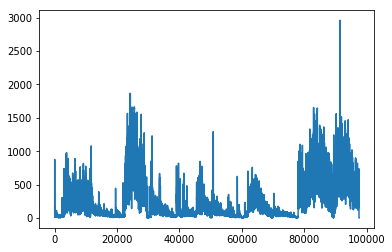

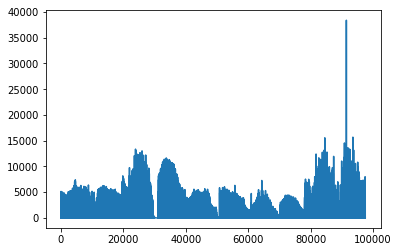

In [112]:
if recursive:
    plt.plot(np.abs([p.tolist() for p in pred_err]))
else:
    plt.plot(np.abs([p for p in pred_err]))
plt.show()

prediction = pd.concat(predictions)
plt.plot(prediction[0][0].values)
plt.show()

Evaluation
==============================================================================================

In [121]:
length = int(len(testX)/5)#5750
system = 0
#pvlib

In [122]:
plots = False
comp = 'pvlib'
data = pd.DataFrame()
for i in range(forecast_horizon):
    if recursive:
        data['+'+str(i+1)+'h-prediction'] = np.pad(prediction[:][0][i].values, (i, 0), mode='constant', constant_values=(np.nan,))[:length]
    else:
        data['+'+str(i+1)+'h-prediction'] = np.pad(prediction[i].values, (i, forecast_horizon-i-1), mode='constant', constant_values=(np.nan,))
length = len(data)
if recursive:
    data['measured'] = pd.DataFrame(np.array(testY).reshape([len(testY), len(target_features)])).iloc[:,0]
else:
    data['measured'] = pd.DataFrame(np.array(testY)).iloc[:,0].append(pd.DataFrame(np.array(testY)).iloc[-forecast_horizon+1:,-1], ignore_index=True).iloc[:length]
data = data.set_index(pd.MultiIndex.from_tuples(idx[:length])).unstack()#

#data['pvlib'] = pvlib[('2015-10-12 00:00:00', system):].unstack()[system].reindex(data.index).iloc[:length]

tmp = pd.DataFrame()
#tmp[comp] = data[comp]
tmp['measured'] = data[('measured', system)]
for i in range(forecast_horizon):
    tmp['+'+str(i+1)+'h-prediction'] = data['+'+str(i+1)+'h-prediction']
data = tmp
data.index = pd.to_datetime(data.index)
data = data.dropna()

m_col = data['measured']
#l_col = data[comp].dropna()

if plots:
    for horizon in range(1, forecast_horizon + 1):
        name = '+' + str(horizon) + 'h-prediction'
        p_col = data[name]

        walkForwardDailyLoss(m_col, p_col, l_col, comp, name)
        scatter_predictions(m_col, p_col, name)

        print('%s test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
        print('%s test RMSE: %.3f' % (comp + ' forecast', math.sqrt(mean_squared_error(m_col, l_col))))
        draw_boxplot(m_col, p_col, l_col, comp, name)
        draw_boxplot_monthly(m_col, p_col, l_col, comp, name)

        m1, m2 = '2016-07-17 00:00:00', '2016-07-17 23:00:00'
        #print('%s nice day RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col[m1:m2], p_col[m1:m2]))))
        #print('%s nice day RMSE: %.3f' % (comp + ' forecast', math.sqrt(mean_squared_error(m_col[m1:m2], l_col[m1:m2]))))
        draw_boxplot(m_col, p_col, l_col, comp, name, m1, m2)

        plot_timeseries(m_col, p_col, l_col, comp, name, end='2015-10-18 00:00:00')
        plot_timeseries(m_col, p_col, l_col, comp, name, start='2017-02-02 10:00:00', end='2017-02-09 10:00:00')
        plot_timeseries(m_col, p_col, l_col, comp, name, start='2017-12-24 00:00:00')
        plot_timeseries(m_col, p_col, l_col, comp, name, start=m1, end=m2)
        plot_timeseries(m_col, p_col, l_col, comp, name)
        plot_timeseries(m_col, p_col, None, comp, name)

        daily_energy_error(m_col, p_col, l_col, comp, name, start='2015-10-13 00:00:00')

        draw_histogram(p_col, m_col, name)
    plot_error_by_hour_of_day(data, comp, 1, forecast_horizon)

    data

In [123]:
l1 = []
l2 = []
for i in range(len(data)-(forecast_horizon-1)):
    sys.stdout.write("%i/%i\r" % (i+1, len(data)-(forecast_horizon-1)))
    sys.stdout.flush()
    forecast = []
    for f in range(1, forecast_horizon+1):
        forecast.append(data['+'+str(f)+'h-prediction'].iloc[f-1 + i])
    forecast
    a = pd.DataFrame()
    a['forecast'] = forecast
    #a['pvlib'] = data['pvlib'].iloc[i:f+i].values
    a['measured'] = data['measured'].iloc[i:f+i].values
    l1.append(mean_squared_error(a.measured, a.forecast))
    #l2.append(mean_squared_error(a.measured, a.pvlib))
print()
print(math.sqrt(pd.DataFrame(l1).mean().values[0]))
#print(math.sqrt(pd.DataFrame(l2).mean().values[0]))

19466/19466
483.8001693613268


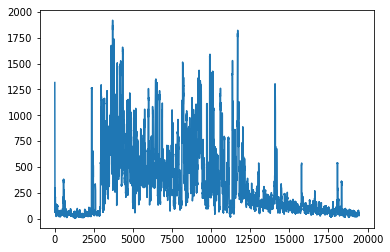

In [124]:
#plt.plot(np.sqrt(l2))
plt.plot(np.sqrt(l1))
plt.show()

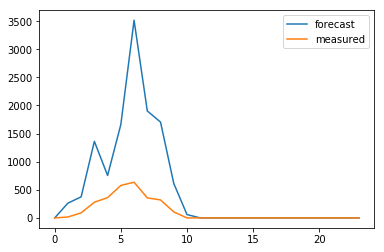

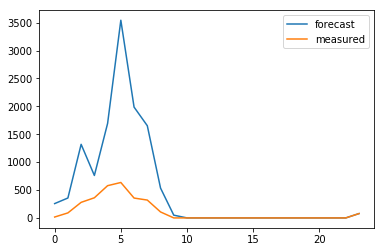

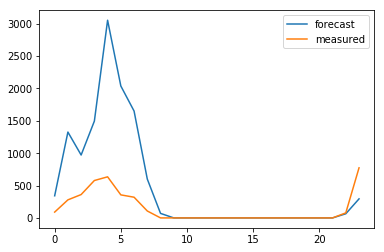

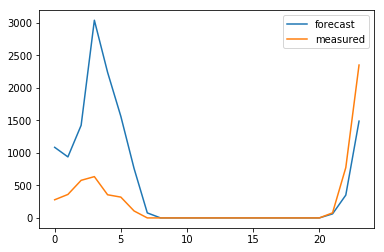

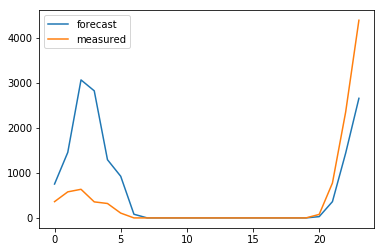

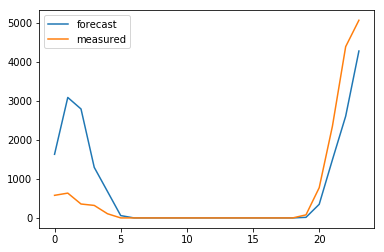

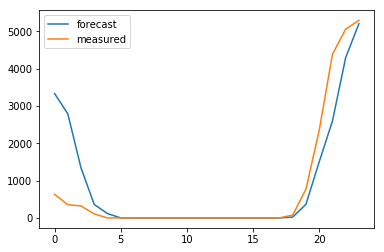

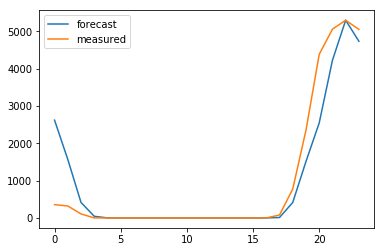

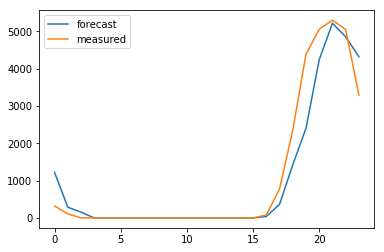

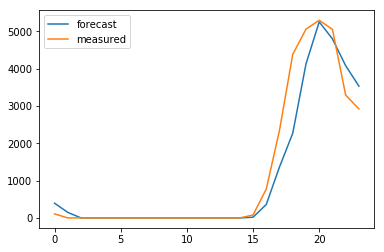

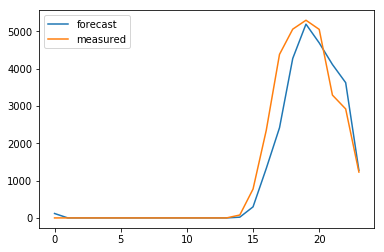

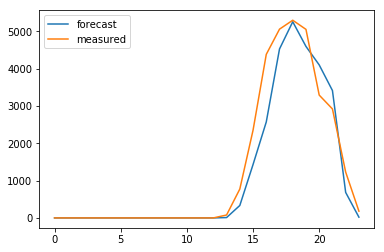

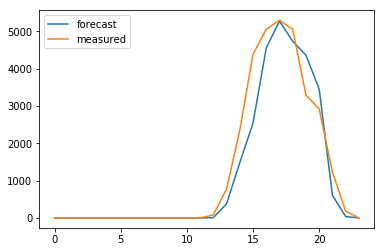

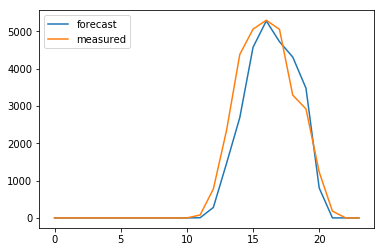

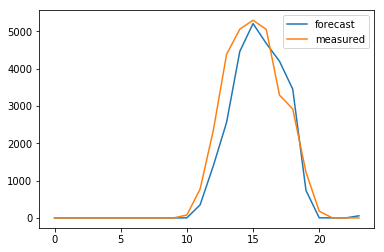

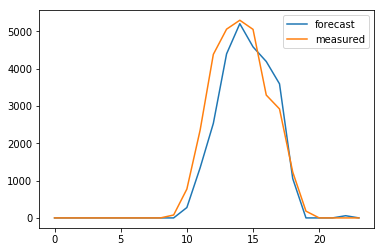

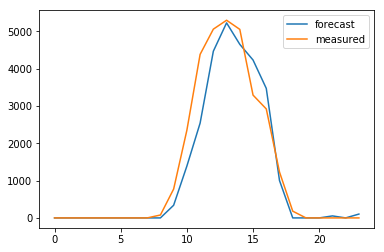

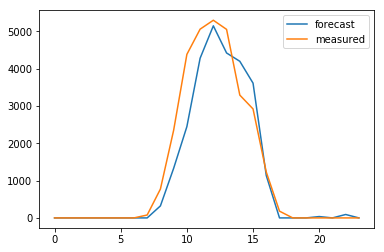

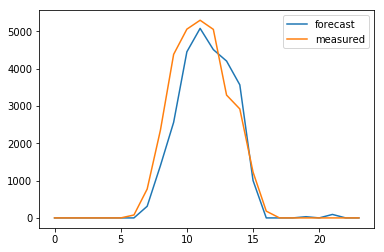

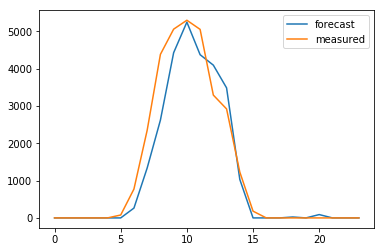

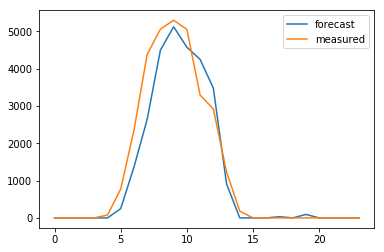

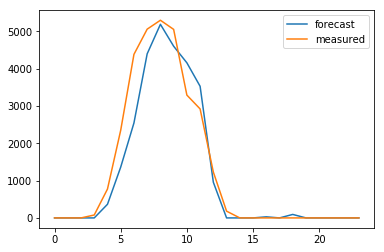

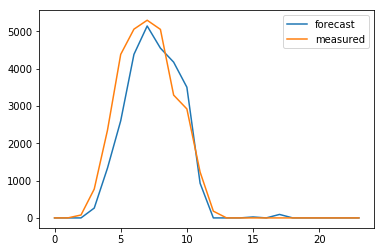

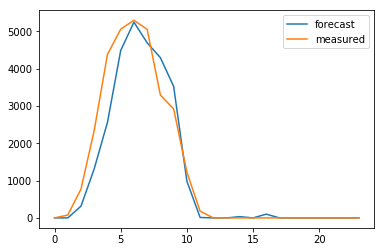

In [125]:
d = 3272
for i in range(d, d+forecast_horizon):
    forecast = []
    for f in range(1, forecast_horizon+1):
        forecast.append(data['+'+str(f)+'h-prediction'].iloc[f-1 + i])
    forecast
    a = pd.DataFrame()
    a['forecast'] = forecast
    #a['pvlib'] = data['pvlib'].iloc[i:f+i].values
    a['measured'] = data['measured'].iloc[i:f+i].values
    a.plot()
    plt.show()

In [ ]:
if recursive:
    persistence1 = pd.DataFrame()
    persistence2 = pd.DataFrame()
    persistence1['measured'] = pd.DataFrame(np.array(testY).reshape([len(testY), len(target_features)])).iloc[:,0]
    persistence2['measured'] = pd.DataFrame(np.array(testY).reshape([len(testY), len(target_features)])).iloc[:,0]
    for f in range(forecast_horizon):
        persistence1['+'+str(f+1)+'h-persistence'] = persistence1['measured'].shift(f+1)
        persistence2['+'+str(f+1)+'h-persistence'] = persistence2['measured'].shift(24)
    persistence1 = persistence1.set_index(pd.MultiIndex.from_tuples(idx)).unstack()
    persistence2 = persistence2.set_index(pd.MultiIndex.from_tuples(idx)).unstack()

In [ ]:
if recursive:

    m1, m2 = '2016-07-17 00:00:00', '2016-07-17 23:00:00'

    print('persistence1:')
    print(persistence1.corr(method='pearson'))
    persistence1 = persistence1.dropna()
    m_col = persistence1['measured']
    print()
    for f in range(1, forecast_horizon + 1):
        name = '+'+str(f)+'h-persistence'
        p_col = persistence1[name]
        j = int(len(m_col) / 24)
        d1 = np.array_split(m_col, j)
        d2 = np.array_split(p_col, j)
        m_err = pd.DataFrame([math.sqrt(mean_squared_error(d1[i], d2[i])) for i in range(len(d1))]).mean()[0]
        print('%s1 test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
        print('daily mean %s1 RMSE: %.3f' % (name, m_err))
        print('%s1 nice day RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col[m1:m2], p_col[m1:m2]))))

    print('\n\n\npersistence2:')
    print(persistence2.corr(method='pearson'))
    persistence2 = persistence2.dropna()
    m_col = persistence2['measured']
    print()
    for f in range(1, forecast_horizon + 1):
        name = '+'+str(f)+'h-persistence'
        p_col = persistence2[name]
        j = int(len(m_col) / 24)
        d1 = np.array_split(m_col, j)
        d2 = np.array_split(p_col, j)
        m_err = pd.DataFrame([math.sqrt(mean_squared_error(d2[i], d1[i])) for i in range(len(d1))]).mean()[0]
        print('%s2 test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
        print('daily mean %s2 RMSE: %.3f' % (name, m_err))
        print('%s2 nice day RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col[m1:m2], p_col[m1:m2]))))

In [ ]:
if method is not 'randfor':
    draw_history(history)
    draw_history(val_history, True)
    print(val_history.history)

In [71]:
print(data.describe())
print(data.corr(method='pearson'))
print(data.corr(method='spearman'))
print(data.corr(method='kendall'))
data.to_csv(dir + 'predictions.csv', encoding='utf-8')

             pvlib     measured  +1h-prediction  +2h-prediction  \
count   277.000000   277.000000      277.000000      277.000000   
mean    453.432005   453.432005      454.805905      454.541522   
std     665.330162   665.330162      663.792559      660.959792   
min       0.000000     0.000000       -0.012998       -0.012455   
25%       0.000000     0.000000       -0.003830       -0.003909   
50%       0.000000     0.000000       -0.001189       -0.000912   
75%     941.789640   941.789640      904.060669      940.001770   
max    2708.466473  2708.466473     2731.598145     2700.553955   

       +3h-prediction  +4h-prediction  +5h-prediction  +6h-prediction  \
count      277.000000      277.000000      277.000000      277.000000   
mean       453.504336      451.189039      449.654486      449.185949   
std        656.347972      653.493719      651.730203      651.400211   
min         -0.012864       -0.012203       -0.010777       -0.010132   
25%         -0.003499       -0.

                    pvlib  measured  +1h-prediction  +2h-prediction  \
pvlib            1.000000  1.000000        0.813271        0.811120   
measured         1.000000  1.000000        0.813271        0.811120   
+1h-prediction   0.813271  0.813271        1.000000        0.891487   
+2h-prediction   0.811120  0.811120        0.891487        1.000000   
+3h-prediction   0.808779  0.808779        0.845132        0.899231   
+4h-prediction   0.807956  0.807956        0.808141        0.851253   
+5h-prediction   0.807324  0.807324        0.783184        0.815623   
+6h-prediction   0.805299  0.805299        0.757076        0.781353   
+7h-prediction   0.804793  0.804793        0.738921        0.754931   
+8h-prediction   0.806121  0.806121        0.735887        0.749595   
+9h-prediction   0.806564  0.806564        0.720714        0.730655   
+10h-prediction  0.806501  0.806501        0.710930        0.720766   
+11h-prediction  0.806628  0.806628        0.703396        0.710720   
+12h-p